In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from collections import defaultdict

# Load the dataset
try:
    df = pd.read_csv('IndianFoodDatasetCSV.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'IndianFoodDatasetCSV.csv' was not found.")
    # Exit if the file is not found
    exit()

Dataset loaded successfully.


In [2]:
# Create an empty bipartite graph
B = nx.Graph()

# Create a dictionary to store the count of each ingredient for each diet
diet_ingredient_counts = defaultdict(lambda: defaultdict(int))

# Use a set to keep track of unique ingredients to add to the graph later
unique_ingredients = set()

for _, row in df.iterrows():
    diet = str(row['Diet']).strip().lower()
    
    # Clean and process ingredients, similar to our previous code
    ingredients = [ing.strip().lower() for ing in str(row['TranslatedIngredients']).split(',') if ing.strip() and ing.strip().lower() != 'nan']
    
    cleaned_ingredients = []
    for ing in ingredients:
        # Regex to remove numbers and units
        ing = re.sub(r'(\b\d+(\.\d+)?\s*(cup|teaspoon|tablespoon|tsp|tbsp|grams|g|kg|litre|ml|pinch|dash|clove|slice|pieces)s?\b|\b\d+(\.\d+)?\b)', '', ing, flags=re.I).strip()
        if ing:
            cleaned_ingredients.append(ing)

    # If the diet is a valid string, update counts
    if diet and diet != 'nan':
        for ing in cleaned_ingredients:
            diet_ingredient_counts[diet][ing] += 1
            unique_ingredients.add(ing)

# Add nodes to the graph
diets = list(diet_ingredient_counts.keys())
ingredients = list(unique_ingredients)

B.add_nodes_from(diets, bipartite=0) # Diets are one set
B.add_nodes_from(ingredients, bipartite=1) # Ingredients are the other set

# Add edges with weights
for diet, ing_counts in diet_ingredient_counts.items():
    for ingredient, count in ing_counts.items():
        if count > 0:
            B.add_edge(diet, ingredient, weight=count)
            
print(f"Bipartite graph created with {B.number_of_nodes()} nodes and {B.number_of_edges()} edges.")


Bipartite graph created with 15829 nodes and 22129 edges.


In [3]:
# Calculate degree centrality for all nodes
degree_centrality = nx.degree_centrality(B)

# Find top 5 most connected diets
print("Top 5 Most Connected Diets:")
top_diets = sorted([node for node in B.nodes() if B.nodes[node]['bipartite'] == 0], 
                      key=lambda x: degree_centrality[x], reverse=True)[:5]

for diet in top_diets:
    print(f"- {diet.capitalize()}: {degree_centrality[diet]:.4f}")

# Find top 10 most connected ingredients
print("\nTop 10 Most Connected Ingredients:")
top_ingredients = sorted([node for node in B.nodes() if B.nodes[node]['bipartite'] == 1], 
                         key=lambda x: degree_centrality[x], reverse=True)[:10]

for ingredient in top_ingredients:
    print(f"- {ingredient}: {degree_centrality[ingredient]:.4f}")


Top 5 Most Connected Diets:
- Vegetarian: 0.7593
- High protein vegetarian: 0.1815
- Non vegeterian: 0.1255
- Eggetarian: 0.0971
- High protein non vegetarian: 0.0738

Top 10 Most Connected Ingredients:
- salt: 0.0006
- / salt: 0.0006
- baking powder: 0.0006
- / curd (dahi / yogurt): 0.0006
- extra virgin olive oil: 0.0006
- honey: 0.0006
- salt - to taste: 0.0006
- / garam masala powder: 0.0006
- inch ginger - grated: 0.0006
- / whole wheat flour: 0.0006


C:\Users\hvish\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hvish\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hvish\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hvish\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pyth

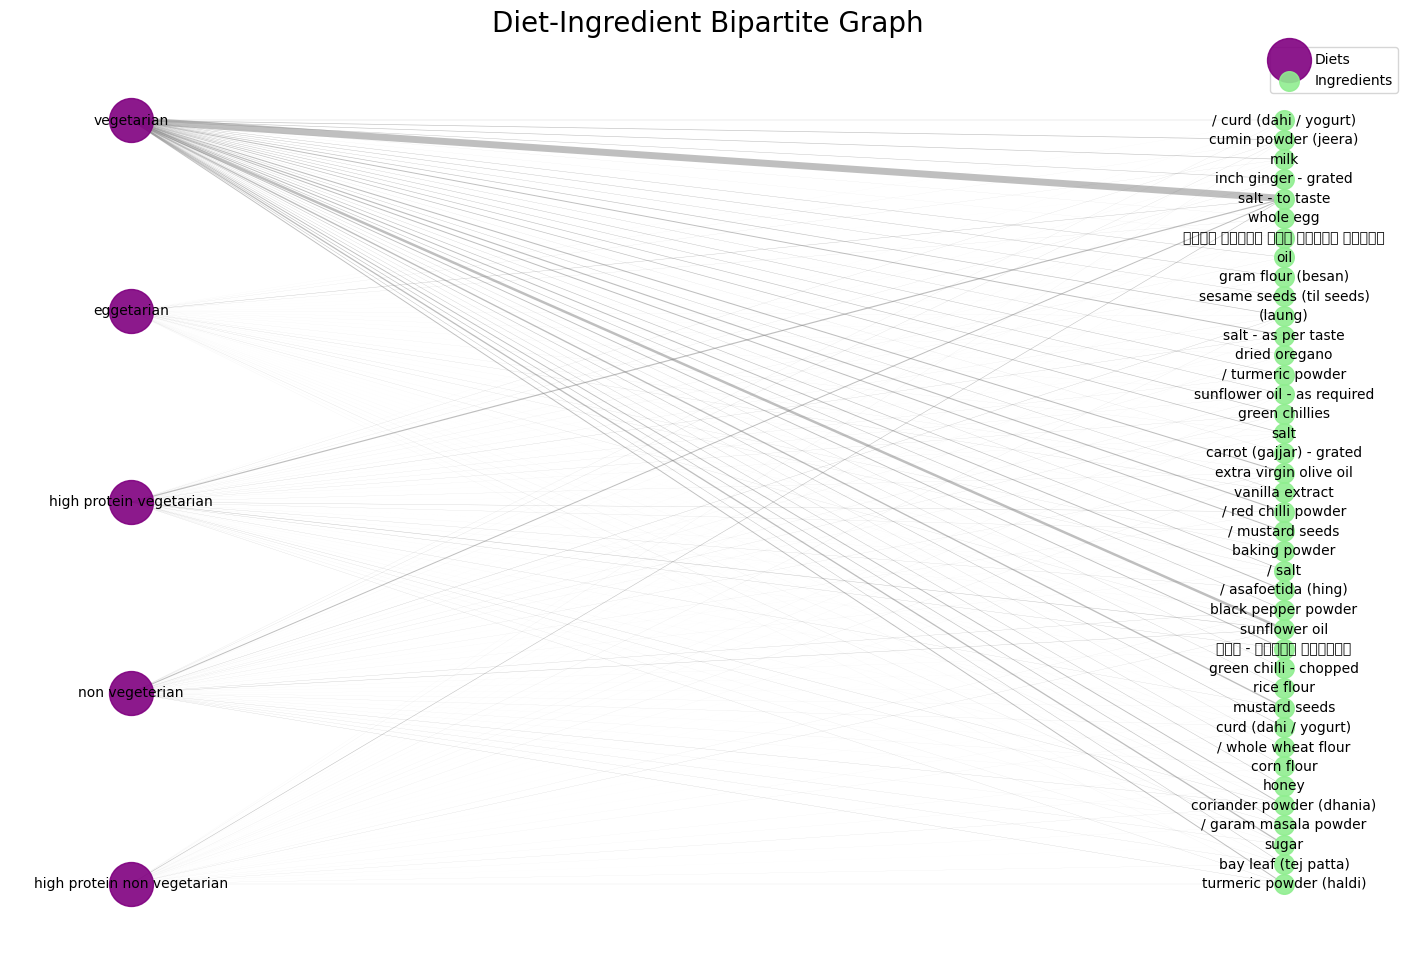

In [4]:
# Visualize the bipartite graph
plt.figure(figsize=(18, 12))

# Separate nodes into two sets
top_diets_for_viz = sorted(diets, key=lambda x: B.degree(x), reverse=True)[:5]
top_ingredients_for_viz = sorted(ingredients, key=lambda x: B.degree(x), reverse=True)[:40] 
top_nodes = top_diets_for_viz + top_ingredients_for_viz

# Create a subgraph of the most connected nodes for clearer visualization
subgraph = B.subgraph(top_nodes)

# Create positions for the nodes
pos = nx.bipartite_layout(subgraph, nodes=top_diets_for_viz)

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos, nodelist=top_diets_for_viz, node_color='purple', node_size=1000, alpha=0.9, label='Diets')
nx.draw_networkx_nodes(subgraph, pos, nodelist=top_ingredients_for_viz, node_color='lightgreen', node_size=200, alpha=0.9, label='Ingredients')

# Draw edges, adjusting width based on weight
edge_weights = [d['weight'] for u, v, d in subgraph.edges(data=True)]
max_weight = max(edge_weights) if edge_weights else 1
edge_widths = [w / max_weight * 5 for w in edge_weights] 
nx.draw_networkx_edges(subgraph, pos, width=edge_widths, edge_color='gray', alpha=0.5)

# Draw labels
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_family='sans-serif')

plt.legend()
plt.title("Diet-Ingredient Bipartite Graph", fontsize=20)
plt.axis('off')
plt.show()